In [50]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import pytz
import gensim
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer
import gc
import string
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from collections import Counter
import pickle
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
sns.set_style(style='darkgrid')
import matplotlib.pyplot as plt
from sklearn import mixture
import re
from sklearn.metrics.pairwise import euclidean_distances,cosine_distances
%matplotlib inline
os.chdir(r"F:\ScoreData\Zee TV")
pd.options.display.max_columns=None

In [2]:
cols=['Source','Host','Link','LocalTime','Authority','Gender','Country','Location','Sentiment','Alexa Rank','Alexa Reach','Title','Snippet','Content','Unique ID','Language','Followers','Following','Summary']

# mm=pd.read_csv('MAYAVI MALING-Mentions.csv',skiprows=13,encoding='utf-8',header=None,parse_dates=[6])
# mm=mm.iloc[:,[1,2,3,6,11,12,13,14,15,16,17,20,21,23,25,26,27,28,29,30,32,33]]
# mm.columns=['Source','Host','Link','LocalTime','Authority','Followers','Following','Age','Gender','Language','Country','Location','Sentiment','Classifications','Alexa Rank','Alexa Reach','Title','Snippet','Content','Summary','Unique ID','Post Source']
# mm.drop(index=mm[mm.Source=='Source'].index,inplace=True)
# mm.head()

# data=pd.read_csv('CHANDRASHEKAR-Mentions.csv',skiprows=13,encoding='utf-8',header=None,parse_dates=[6])

all_files=os.listdir('./new')
print(all_files[:5])

gcd=os.getcwd()
os.chdir('./new')
all_files=os.listdir()
mentions=[_ for _ in all_files if _.__contains__("Mentions")]
shows=pd.DataFrame()
nf=0
for filename in mentions:
    try:
        data=pd.read_csv(filename,skiprows=5,parse_dates=[3],usecols=cols)
        data['showname']=filename.split(".")[0]
        shows=pd.concat([shows,data],axis=0)
#         print(".............{} is done.......".format(filename))
    except Exception as  e:
        print("filename {} with exception {}".format(filename,e))
#         print("Parsing {}...../n".format(filename))
        continue
        nf+=1
        try:
            data=pd.read_csv(filename,skiprows=13,encoding='utf-8',header=None,parse_dates=[6])
            data=data.iloc[:,[1,2,3,6,11,12,13,14,15,16,17,20,21,23,25,26,27,28,29,30,32,33]]
            data.columns=['Source','Host','Link','LocalTime','Authority','Followers','Following','Age','Gender','Language','Country','Location','Sentiment','Classifications','Alexa Rank','Alexa Reach','Title','Snippet','Content','Summary','Unique ID','Post Source']
            data.drop(index=mm[mm.Source=='Source'].index,inplace=True)
            data=data[cols]
            data['showname']=filename.split(".")[0]
            shows=pd.concat([shows,data],axis=0)
        except Exception as e:
            print("Encountered second  exception for {}/n".format(filename,e))
            continue
        continue
print("\n \n Total not found shows {:d}".format(nf))
os.chdir(gcd)

shwlst=shows.showname.unique()

pattern=re.compile("(\d|\s)")
nname={sname:pattern.sub('',sname) for sname in shwlst}

shows['nname']=shows['showname'].replace(to_replace=nname)

In [16]:
# showcount=shows.groupby('nname')['Unique ID'].nunique().to_frame()
# train=pd.DataFrame.sample(showcount,frac=0.8,random_state=101)
# test=showcount[~showcount.index.isin(train.index)]
# train.shape,test.shape

# train=pd.read_csv(r'F:\ScoreData\Zee TV\train_showname_ratings.csv')
# train=train.groupby('Showname').max()
# train.to_csv('train_showname_ratings_max.csv')

In [8]:
with open("read_files",'wb') as rf:
    pickle.dump(shows,rf)

Crime patrol and Big boss had a long break between telecast, so  the first initial rating was removed

In [26]:
def create_subset_by_days(df,days=30):
    dt_min=df.groupby('nname')['LocalTime'].min().to_frame().reset_index()
    dt_min['max_dt']=dt_min['LocalTime'].apply(lambda x: x + dt.timedelta(days=days))
    df=df.merge(dt_min[['nname','max_dt']],on='nname',how='left')
    df=df[df.LocalTime<=df.max_dt].copy()
    print(df.groupby('nname')['LocalTime'].apply(lambda x:max(x)-min(x)))
    return df

In [5]:
with open(r"F:\ScoreData\Zee TV\read_files",'rb') as rf:
    shows=pickle.load(rf)

In [3]:
def tokens(tokenizer,tweets):
    tweets=tweets.lower()
    tokens=tokenizer.tokenize(tweets)
    tokens=filter(lambda x:not x.startswith('http'),tokens)
    return list(tokens)

def create_embeddings(unique_tweets,size,tweets_tokens,keyed):
    embeddings=np.zeros(shape=(len(unique_tweets),size))
    for i,tweet in enumerate(tweets_tokens):
        sm=0
        for word in tweet:
            try:
                embeddings[i]+=keyed[word]
            except KeyError as e:
                print("KeyError occurred")
                print(tweet)
        embeddings[i]=embeddings[i]/len(tweet)
    return embeddings

def fit_clusters(clf,embeddings):
    clus={}
    clf.fit(embeddings)
    clus['labels']=pd.Series(clf.labels_)
    clus['score']=clf.inertia_
#     clus['cls']=clf
    clus['centroids']=clf.cluster_centers_
    return clus

def create_clusters(rng,embeddings,unique_tweets):
    cluster_file=pd.DataFrame({'tweets':unique_tweets})
    scores=[]
    centers=[]
    for i in rng:
        km=KMeans(n_clusters=i,n_jobs=-1,random_state=101)
        clus=fit_clusters(km,embeddings)
        scores.append(clus['score'])
        cluster_file['cluster_{}'.format(i)]=clus['labels']
        centers.append(clus['centroids'])
        del km
        del clus
        gc.collect()
    return cluster_file,scores,centers
def plot_homogeinity(scores,rng):
    fig,ax=plt.subplots()
    sns.scatterplot(x=rng,y=scores,ax=ax)
    ax.set(title="Homogeneity",xlabel="Clusters",ylabel="total rss")
    plt.plot()

def clustering(unique_tweets,model_name,rng_cluster,size=100,overwrite=False):
    cdr=os.getcwd()
    os.chdir("./cache")
    unique_tweets=list(filter(lambda x:len(x)!=0,unique_tweets))
    tokenizer=TweetTokenizer()
    tweets_tokens=[tokens(tokenizer,x) for x in unique_tweets ]
    if overwrite:
        model=Word2Vec(tweets_tokens,size=size,min_count=1)
        model.train(tweets_tokens,total_examples=len(tweets_tokens),epochs=10)
        model.save("{}.model".format(model_name))
        keyed=model.wv
        del model
    else:
        try:
            model=Word2Vec.load("{}.model".format(model_name))
            keyed=model.wv
            del model
        except Exception as e:
            print("............Exception occurred...........\n{}".format(e))
    if os.path.isfile("{}.embed".format(model_name)) & ~overwrite:
        with open("{}.embed".format(model_name),"rb") as eb:
            embeddings=pickle.load(eb)
    else:
        embeddings=create_embeddings(unique_tweets,size,tweets_tokens,keyed)
        with open("{}.embed".format(model_name),"wb") as we:
            pickle.dump(embeddings,we)
    cluster_file,scores,centers=create_clusters(rng_cluster,embeddings,unique_tweets)
    plot_homogeinity(scores,rng_cluster)
    cluster_file.to_csv("{}.csv".format(model_name))
    return cluster_file,scores,centers
    
    

In [6]:
shows.head(2)

,Source,Host,Link,LocalTime,Authority,Gender,Country,Location,Sentiment,Alexa Rank,Alexa Reach,Title,Snippet,Content,Unique ID,Language,Followers,Following,Summary,showname,nname
0,TWITTER,http://twitter.com/ASHWANI11345063/,http://twitter.com/ASHWANI11345063/statuses/10...,2018-10-25 23:29:56,0,Male,NaN,NaN,None,0,0,@ASHWANI11345063,@AndTVOfficial YE JO PERFECT PATI KA SHOW HAI ...,@AndTVOfficial YE JO PERFECT PATI KA SHOW HAI ...,23723083,TL,1,8,NaN,andtv-show-perfect-pati-Mentions,andtv-show-perfect-pati-Mentions
1,INSTAGRAM,http://instagram.com/dabh_big_fan_bulgaria,https://www.instagram.com/p/BpXjXNVC03A/,2018-10-25 15:34:56,0,NaN,BG,Sofia;-42;-Bulgaria,Positive,0,0,dabh_big_fan_bulgaria,"Ayush Anand in ,,Perfect Pati"" 25/10/18 Episod...","Ayush Anand in ,,Perfect Pati"" 25/10/18 Episod...",23709925,EN,0,0,NaN,andtv-show-perfect-pati-Mentions,andtv-show-perfect-pati-Mentions


In [10]:
show.groupby(['Source','nname'])['Unique ID'].nunique().to_frame().to_csv('source_show_count.csv')

In [9]:
def get_unique_tweets(show,shwnm=None,host=None):
    if (shwnm is None) | (host is None):
        df=show[(show.Source=="TWITTER")].copy()
    else:
        df=show[(show.Source=="TWITTER")& (show.nname==shwnm)& ~(show.Host==host)].copy()
    df['original']=~df.Content.str.startswith(("RT","QT"))
    print("Total tweets for {2} {1:d} and unique tweets w/o processing {0:d}".format(df.loc[df.original,'Unique ID'].nunique(),df['Unique ID'].nunique(),shwnm))
    df['cleanContent']=df.Content.str.replace(r"http.*[\s\n]","")
    df.drop_duplicates('cleanContent',keep='first',inplace=True)
    df['length']=df.cleanContent.apply(lambda x:len(x))
    df=df.loc[(df.length>0) & (df.original),['Unique ID','Content','nname','cleanContent']].copy()
    print("unique tweets with processing",df.shape[0])
    return df


In [6]:
ishq=show[(show.Source=="TWITTER")& (show.nname=="zee-tv---show---ishq-subhan-allah-Mentions")& ~(show.Host=="http://twitter.com/ZeeTV/")]
ishq['original']=~ishq.Content.str.startswith(("RT","QT"))
print("Total tweets for Ishq {1:d} and unique tweets {0:d}".format(ishq.loc[ishq.original,'Unique ID'].nunique(),ishq['Unique ID'].nunique()))

ishq['cleanContent']=ishq.Content.str.replace(r"http.*[\s\n]","")
unique_tweets=ishq.loc[ishq.original,"cleanContent"].unique()
print("unique tweets",len(unique_tweets))


Total tweets for Ishq 12256 and unique tweets 7470
unique tweets 6452


S:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
S:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [40]:
unique_tweets[:5]

array(['Ishq Subhan Allah - इश्क़ सुभान अल्लाह - Episode 38 - May 04, 2018 - Best Scene via ',
       'Ishq Subhan Allah – इश्क़ सुभान अल्लाह – Episode 38 – May 04, 2018 – Best Scene ',
       'Most watched Indian television shows: Kundali Bhagya and Ishq Subhan Allah top the BARC charts.. ',
       'Ishq Subhan Allah 4th May 2018 Episode 37 #EishaSingh #AdnanKhan #Zabir #Zara #Kabir #IshqSubhanAllah #ZeeTV ~PART 11~ PRECAP~ ',
       'Ishq Subhan Allah 4th May 2018 Episode 37 #EishaSingh #AdnanKhan #Zabir #Zara #Kabir #IshqSubhanAllah #ZeeTV ~PART 10~ PRECAP '],
      dtype=object)

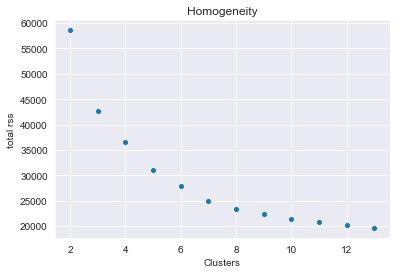

In [8]:
os.chdir(r"F:\ScoreData\Zee TV")
cluster_file,scores,centers=clustering(unique_tweets[:],"ishq",rng_cluster=np.arange(2,14),size=50,overwrite=True)

In [8]:
def top5comments(centers,nbrs,cluster_tweet,embed,filename=None):
    nn=NearestNeighbors(n_neighbors=nbrs,algorithm='auto')
    with open("{}.embed".format(embed),'rb') as rf:
        embeddings=pickle.load(rf)
    nn.fit(embeddings)
    _,nearest=nn.kneighbors(centers)
    cluster=centers.shape[0]
    df=cluster_tweet[['tweets','cluster_{}'.format(int(cluster))]]
    df=df.iloc[nearest.ravel(),:]
    if filename is not None:
        df.to_csv("{}.csv".format(filename),index=False,encoding='utf-8')
    return df,nearest
gc.collect()

71

In [15]:
df,nearest=top5comments(centers[4],15,cluster_file,"Ishq_cluster_6")

In [19]:
Counter(cluster_file.cluster_6)

Counter({0.0: 1975,
         1.0: 165,
         2.0: 2170,
         3.0: 587,
         4.0: 255,
         5.0: 1299,
         nan: 1})

### Cluster for juzzbatt

In [27]:
data30=create_subset_by_days(shows.copy(),days=30)

nname
BIGGBOSS-Mentions                                          30 days 00:00:00
DILHITOHAI-Mentions                                        29 days 23:56:45
HARSHAAKHPEULLUBAITHAAHAI-Mentions                         29 days 22:47:28
JIJAJICHHATPARHAIN-Mentions                                29 days 23:58:05
KHICHDI-Mentions                                           29 days 17:11:18
KRISHNACHALILONDON-Mentions                                29 days 23:22:06
NAZAR-Mentions                                             29 days 23:07:11
andtv-show-perfect-pati-Mentions                           29 days 13:49:53
andtvofficial-show-bitti-businesswali-Mentions             29 days 21:33:02
andtvofficial-show-high-fever-Mentions                     29 days 20:46:04
andtvofficial-show-laal-ishq-Mentions                      29 days 07:23:12
andtvofficial-show-love-me-india-Mentions                  29 days 23:59:25
andtvofficial-show-mitegi-lakshmanrekha-Mentions           29 days 23:34:51
andtvo

In [28]:
ut_juzz=get_unique_tweets(data30.copy(),shwnm="zee-tv---show---juzzbaaat-Mentions",host="http://twitter.com/ZeeTV/")

Total tweets for zee-tv---show---juzzbaaat-Mentions 47531 and unique tweets 8709
unique tweets 7968


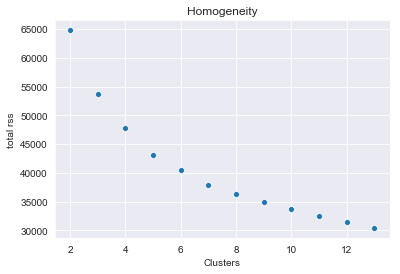

In [31]:
os.chdir(r"F:\ScoreData\Zee TV")
cluster_juzz,scores_juzz,centers_juzz=clustering(ut_juzz[:],"juzzbatt",rng_cluster=np.arange(2,14),size=50,overwrite=True)

In [43]:
def tweets_cluster(showname,host,size,embed,filename):
    ut_juzz=get_unique_tweets(data30.copy(),shwnm=showname,host=host)
    os.chdir(r"F:\ScoreData\Zee TV")
    cluster_juzz,scores_juzz,centers_juzz=clustering(ut_juzz[:],embed,rng_cluster=np.arange(2,14),size=size,overwrite=True)
    print(Counter(cluster_juzz.cluster_6))
    _,_=top5comments(centers_juzz[4],15,cluster_juzz,embed,filename)

Total tweets for BIGGBOSS-Mentions 144448 and unique tweets 18799
unique tweets 18054
Counter({1: 7010, 3: 4012, 5: 3521, 0: 1805, 4: 1089, 2: 616})


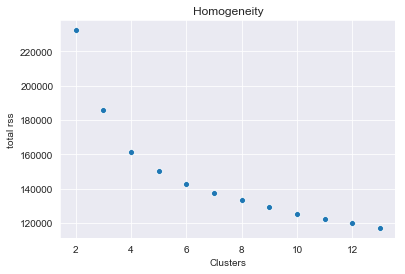

In [44]:
tweets_cluster("BIGGBOSS-Mentions","http://twitter.com/ColorsTV/",100,"bb","bb_closest")

Total tweets for zee-tv---show---juzzbaaat-Mentions 47531 and unique tweets 8709
unique tweets 7968
Counter({0: 2951, 1: 2494, 3: 1007, 5: 910, 2: 509, 4: 96})


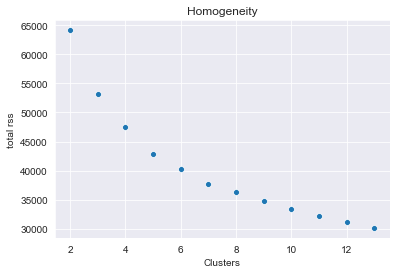

In [45]:
tweets_cluster("zee-tv---show---juzzbaaat-Mentions","http://twitter.com/ZeeTV/",100,"juzzbatt","juzz_closest")

### Create word2vec on whole set yet creating clusters based on input showname

In [52]:
os.chdir(r"F:\ScoreData\Zee TV\cache")
def create_model(df_subset,model_name,size=100,epochs=10,overwrite=False):
    ut_original=df_subset.cleanContent.values
    df_subset=df_subset.sample(frac=1,random_state=1,replace=False)
    unique_tweets=df_subset.cleanContent.values
    del df_subset
    tokenizer=TweetTokenizer()
    tweets_tokens=[tokens(tokenizer,x) for x in unique_tweets ]
    model=Word2Vec(tweets_tokens,size=size,min_count=1)
    model.train(tweets_tokens,total_examples=len(tweets_tokens),epochs=epochs)
    model.save("{}.model".format(model_name))
    del tweets_tokens
    del model
    gc.collect()
    
def create_show_embedding(ut_original,model_name,showname,size=100):
    tokenizer=TweetTokenizer()
    tweets_tokens=[tokens(tokenizer,x) for x in ut_original ]
    model=Word2Vec.load("{}.model".format(model_name))
    embeddings=create_embeddings(ut_original,size,tweets_tokens,model.wv)
    with open("{}.embed".format(showname),"wb") as we:
        pickle.dump(embeddings,we)
    del model
    print("The shape of embeddings ",embeddings.shape)
    return embeddings
    
def create_show_embedding_on_whole(df,showname,model_name,rng_cluster):
    os.chdir(r"F:\ScoreData\Zee TV\cache")
    with open("{}.embed".format(model_name),"rb") as we:
        embeddings=pickle.load(we)
    unique_tweets=df.loc[df.nname==showname,'cleanContent']
    showindex=unique_tweets.index
    showembeddings=embeddings[showindex,:]
    cluster_file,scores,centers=create_clusters(rng_cluster,showembeddings,unique_tweets.values)
    plot_homogeinity(scores,rng_cluster)
    cluster_file.to_csv("{}.csv".format(showname))
    return cluster_file,scores,centers

def create_top_comments(df,showname,centers,nbrs,cluster_tweet,model_name,filename=None):
    os.chdir(r"F:\ScoreData\Zee TV\cache")
    nn=NearestNeighbors(n_neighbors=nbrs,algorithm='auto')
    with open("{}.embed".format(model_name),'rb') as rf:
        embeddings=pickle.load(rf)
    unique_tweets=df.loc[df.nname==showname,'cleanContent']
    showindex=unique_tweets.index
    showembeddings=embeddings[showindex,:]
    nn.fit(showembeddings)
    _,nearest=nn.kneighbors(centers)
    cluster=centers.shape[0]
    df=cluster_tweet[['tweets','cluster_{}'.format(int(cluster))]]
    df=df.iloc[nearest.ravel(),:]
    if filename is not None:
        df.to_csv("{}.csv".format(filename),index=False,encoding='utf-8')
    return df,nearest

In [10]:
df=get_unique_tweets(shows,shwnm=None,host=None)

Total tweets for None 1299243 and unique tweets w/o processing 274005
unique tweets with processing 238795


In [11]:
df.head()

,Unique ID,Content,nname,cleanContent
0,23723083,@AndTVOfficial YE JO PERFECT PATI KA SHOW HAI ...,andtv-show-perfect-pati-Mentions,@AndTVOfficial YE JO PERFECT PATI KA SHOW HAI ...
9,23658245,#SuperExclusive #TRP #TRPDay @AndTVOfficial Al...,andtv-show-perfect-pati-Mentions,#SuperExclusive #TRP #TRPDay @AndTVOfficial Al...
10,23657707,"#AndTV: #Agnifera 0.2, #VikramBetaal 0.4, #Par...",andtv-show-perfect-pati-Mentions,"#AndTV: #Agnifera 0.2, #VikramBetaal 0.4, #Par..."
29,23173705,@AndTVOfficial your show *perfect pati* is abs...,andtv-show-perfect-pati-Mentions,@AndTVOfficial your show *perfect pati* is abs...
39,23069813,"#AndTV: #Agnifera 0.3, #ParamavatarShriKrishna...",andtv-show-perfect-pati-Mentions,"#AndTV: #Agnifera 0.3, #ParamavatarShriKrishna..."


In [12]:
create_model(df.copy(),'combined',size=100,epochs=10,overwrite=False)

The shape of embeddings  (238795, 100)


Total tweets for BIGGBOSS-Mentions 175315 and unique tweets w/o processing 23841
unique tweets with processing 22806
The shape of embeddings  (22806, 100)
Counter({3: 6522, 4: 5397, 1: 4535, 2: 3318, 5: 2256, 0: 778})


TypeError: 'NoneType' object is not iterable

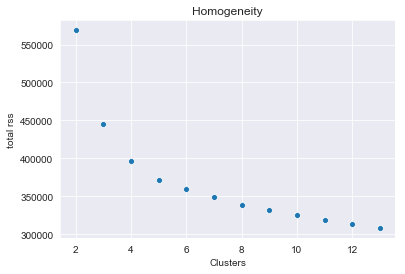

In [50]:
cluster_file_bb,scores_bb,centers_bb=show_cluster_combined_model(shows.copy(),"BIGGBOSS-Mentions","http://twitter.com/ColorsTV/","combined")

Total tweets for zee-tv---show---juzzbaaat-Mentions 63207 and unique tweets w/o processing 11401
unique tweets with processing 10463
The shape of embeddings  (10463, 100)
Counter({4: 3970, 2: 2664, 1: 1604, 3: 1271, 0: 829, 5: 125})


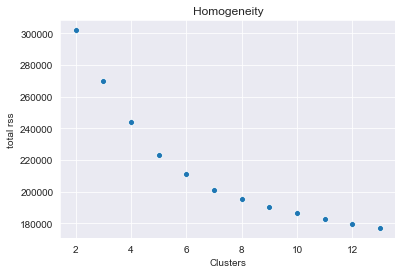

In [52]:
cluster_file_bb,scores_bb,centers_bb=show_cluster_combined_model(shows.copy(),"zee-tv---show---juzzbaaat-Mentions","http://twitter.com/ZeeTV/","combined",clstr=8)

Total tweets for HARSHAAKHPEULLUBAITHAAHAI-Mentions 43258 and unique tweets w/o processing 6668
unique tweets with processing 4614
The shape of embeddings  (4614, 100)
Counter({1: 1294, 0: 1284, 4: 679, 3: 629, 5: 531, 2: 197})


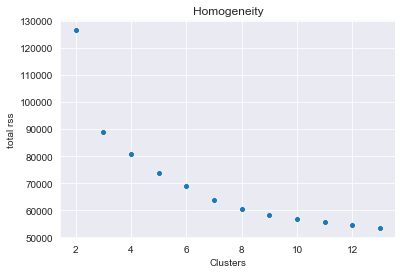

In [55]:
cluster_file_bb,scores_bb,centers_bb=show_cluster_combined_model(shows.copy(),"HARSHAAKHPEULLUBAITHAAHAI-Mentions","http://twitter.com/StarPlus/","combined",clstr=8)

Total tweets for zeetv-show-did-lil-masters-Mentions 14061 and unique tweets w/o processing 6766
unique tweets with processing 6091
The shape of embeddings  (6091, 100)
Counter({1: 1928, 2: 1894, 3: 1449, 5: 373, 0: 357, 4: 90})


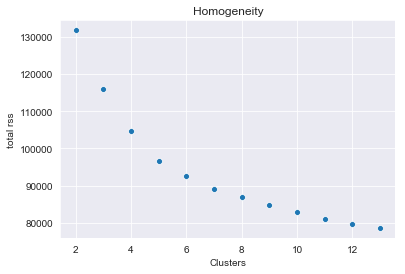

In [58]:
cluster_file_bb,scores_bb,centers_bb=show_cluster_combined_model(shows.copy(),"zeetv-show-did-lil-masters-Mentions","http://twitter.com/ZeeTV/","combined",clstr=6)

In [38]:
os.chdir(r"F:\ScoreData\Zee TV\cache")
official_handle=["http://twitter.com/AndTVOfficial/","http://twitter.com/ColorsTV/","http://twitter.com/SonySABTV/","http://twitter.com/SonyTV/","http://twitter.com/StarPlus/","http://twitter.com/ZeeTV/"]
def create_model(df_subset,model_name,size=100,epochs=10,overwrite=False):
    ut_original=df_subset.cleanContent.values
    df_subset=df_subset.sample(frac=1,random_state=1,replace=False)
    unique_tweets=df_subset.cleanContent.values
    del df_subset
    tokenizer=TweetTokenizer()
    tweets_tokens=[tokens(tokenizer,x) for x in unique_tweets ]
    model=Word2Vec(tweets_tokens,size=size,min_count=1)
    model.train(tweets_tokens,total_examples=len(tweets_tokens),epochs=epochs)
    model.save("{}.model".format(model_name))
    del tweets_tokens
    del model
    gc.collect()

def get_unique_tweets(show,shwnm=None):
    if (shwnm is None):
        df=show[(show.Source=="TWITTER") & ~(show.Host.isin(official_handle))].copy()
    else:
        df=show[(show.Source=="TWITTER")& (show.nname==shwnm)& ~(show.Host.isin(official_handle))].copy()
    df['original']=~df.Content.str.startswith(("RT","QT"))
    print("Total tweets for {2} {1:d} and unique tweets w/o processing {0:d}".format(df.loc[df.original,'Unique ID'].nunique(),df['Unique ID'].nunique(),shwnm))
    df['cleanContent']=df.Content.str.replace(r"http.*[\s\n]","")
    df.drop_duplicates('cleanContent',keep='first',inplace=True)
    df['length']=df.cleanContent.apply(lambda x:len(x))
    df=df.loc[(df.length>0) & (df.original),['Unique ID','Content','nname','cleanContent']].copy()
    print("unique tweets with processing",df.shape[0])
    return df

def tokens(tokenizer,tweets):
    tweets=tweets.lower()
    tokens=tokenizer.tokenize(tweets)
    tokens=filter(lambda x:not x.startswith('http'),tokens)
    return list(tokens)

def create_embeddings(unique_tweets,size,tweets_tokens,keyed):
    embeddings=np.zeros(shape=(len(unique_tweets),size))
    for i,tweet in enumerate(tweets_tokens):
        sm=0
        for word in tweet:
            try:
                embeddings[i]+=keyed[word]
            except KeyError as e:
                print("KeyError occurred")
                print(tweet)
        embeddings[i]=embeddings[i]/len(tweet)
    return embeddings

def create_show_embedding(ut_original,model_name,showname=None,size=100):
    tokenizer=TweetTokenizer()
    tweets_tokens=[tokens(tokenizer,x) for x in ut_original ]
    model=Word2Vec.load("{}.model".format(model_name))
    embeddings=create_embeddings(ut_original,size,tweets_tokens,model.wv)
    with open("{}.embed".format(showname),"wb") as we:
        pickle.dump(embeddings,we)
    del model
    print("The shape of embeddings ",embeddings.shape)
    return embeddings

def fit_clusters(clf,embeddings):
    clus={}
    clf.fit(embeddings)
    clus['labels']=pd.Series(clf.labels_)
    clus['score']=clf.inertia_
#     clus['cls']=clf
    clus['centroids']=clf.cluster_centers_
    return clus

def create_clusters(rng,embeddings,unique_tweets):
    cluster_file=pd.DataFrame({'tweets':unique_tweets})
    scores=[]
    centers=[]
    for i in rng:
        km=KMeans(n_clusters=i,n_jobs=-1,random_state=101)
        clus=fit_clusters(km,embeddings)
        scores.append(clus['score'])
        cluster_file['cluster_{}'.format(i)]=clus['labels']
        centers.append(clus['centroids'])
        del km
        del clus
        gc.collect()
    return cluster_file,scores,centers

def plot_homogeinity(scores,rng):
    fig,ax=plt.subplots()
    sns.scatterplot(x=rng,y=scores,ax=ax)
    ax.set(title="Homogeneity",xlabel="Clusters",ylabel="total rss")
    plt.plot()

def top5comments(centers,nbrs,cluster_tweet,embed,filename=None):
    nn=NearestNeighbors(n_neighbors=nbrs,algorithm='auto')
    with open("{}.embed".format(embed),'rb') as rf:
        embeddings=pickle.load(rf)
    nn.fit(embeddings)
    _,nearest=nn.kneighbors(centers)
    cluster=centers.shape[0]
    df=cluster_tweet[['tweets','cluster_{}'.format(int(cluster))]]
    df=df.iloc[nearest.ravel(),:]
    if filename is not None:
        df.to_csv("{}.csv".format(filename),index=False,encoding='utf-8')
    return df,nearest

def show_cluster_combined_model(shows,shwnm,model_name,clstr=6,rng_cluster=np.arange(2,14)):
    kalerein_mentions=get_unique_tweets(shows.copy(),shwnm=shwnm)
    embeddings=create_show_embedding(kalerein_mentions.cleanContent.values,model_name,shwnm)
    cluster_file,scores,centers=create_clusters(rng_cluster,embeddings,kalerein_mentions.cleanContent.values)
    cluster_file.to_csv("{}_clustered.csv".format(shwnm))
    plot_homogeinity(scores,rng_cluster)
    _,_=top5comments(centers[clstr-rng_cluster[0]],15,cluster_file,shwnm,"{}_nearest".format(shwnm))
    print(Counter(cluster_file["cluster_{}".format(clstr)]))
    return cluster_file,scores,centers

def create_subclusters(ut,model_name,subClusterFilename,clstr=6,rng_cluster=np.arange(2,14)):
    embeddings=create_show_embedding(ut,model_name,subClusterFilename)
    cluster_file,scores,centers=create_clusters(rng_cluster,embeddings,ut)
    cluster_file.to_csv("{}_clustered.csv".format(subClusterFilename))
    plot_homogeinity(scores,rng_cluster)
    _,_=top5comments(centers[clstr-rng_cluster[0]],15,cluster_file,subClusterFilename,"{}_nearest".format(subClusterFilename))
    print(Counter(cluster_file["cluster_{}".format(clstr)]))
    return cluster_file,scores,centers


Total tweets for zeetv---show---kaleerein-Mentions 77701 and unique tweets w/o processing 35669
unique tweets with processing 30656
The shape of embeddings  (30656, 100)
Counter({5: 9734, 3: 8274, 1: 5329, 2: 5033, 0: 1783, 4: 503})


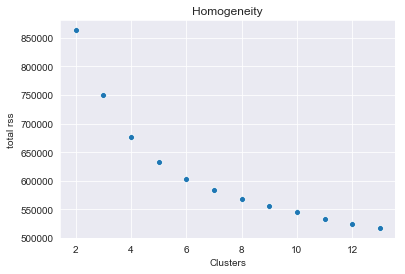

In [11]:
cluster_file,scores,centers=show_cluster_combined_model(shows.copy(),"zeetv---show---kaleerein-Mentions","combined")

In [29]:
shwnm="zeetv---show---kaleerein-Mentions"
_,_=top5comments(centers[13-2],15,cluster_file,shwnm,"{}_nearest".format(shwnm))

In [30]:
Counter(cluster_file.cluster_13)

Counter({0: 2849,
         1: 318,
         2: 3942,
         3: 3574,
         4: 503,
         5: 1318,
         6: 4556,
         7: 2749,
         8: 3021,
         9: 3998,
         10: 657,
         11: 261,
         12: 2910})

The shape of embeddings  (1783, 100)
Counter({1: 1214, 2: 311, 0: 258})


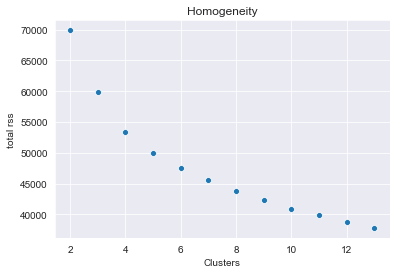

In [27]:
kal_6=cluster_file.loc[cluster_file.cluster_6.isin([0,1,3]),["tweets","cluster_6"]].copy()
kal_6_0,_,_=create_subclusters(kal_6.loc[kal_6.cluster_6==0,"tweets"].values,"combined","kaliren_6_0_",clstr=3)

The shape of embeddings  (1783, 100)
Counter({1: 475, 4: 318, 2: 260, 0: 259, 3: 240, 5: 231})


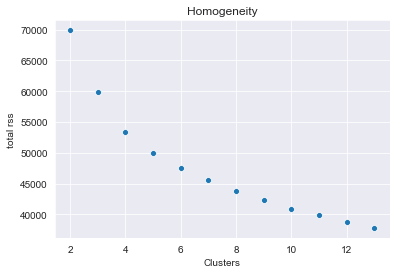

In [28]:
kal_6_0_6,_,_=create_subclusters(kal_6.loc[kal_6.cluster_6==0,"tweets"].values,"combined","kaliren_6_0_6",clstr=6)

Total tweets for HARSHAAKHPEULLUBAITHAAHAI-Mentions 43258 and unique tweets w/o processing 6668
unique tweets with processing 4614
The shape of embeddings  (4614, 100)
Counter({0: 1047, 11: 713, 4: 521, 2: 407, 6: 358, 1: 332, 3: 305, 10: 263, 12: 251, 7: 169, 9: 155, 8: 51, 5: 42})


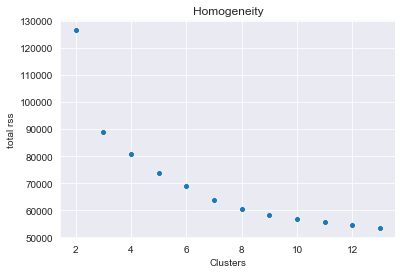

In [31]:
cluster_file,scores,centers=show_cluster_combined_model(shows.copy(),"HARSHAAKHPEULLUBAITHAAHAI-Mentions","combined",clstr=13)

Total tweets for colorstv-show-bepannaah-Mentions 187314 and unique tweets w/o processing 31539
unique tweets with processing 26893
The shape of embeddings  (26893, 100)
Counter({1: 5385, 4: 4230, 6: 3378, 12: 3204, 2: 2106, 8: 1974, 3: 1601, 0: 1448, 7: 1395, 11: 842, 5: 621, 9: 574, 10: 135})


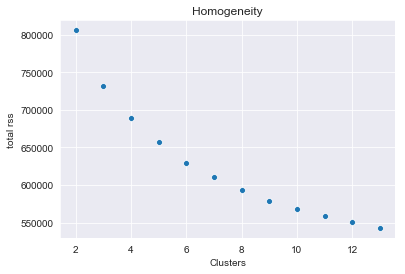

In [32]:
cluster_file,scores,centers=show_cluster_combined_model(shows.copy(),"colorstv-show-bepannaah-Mentions","combined",clstr=13)

Total tweets for sony-tv-show-dus-ka-dum-Mentions 102423 and unique tweets w/o processing 10271
unique tweets with processing 8762
The shape of embeddings  (8762, 100)
Counter({1: 1558, 8: 1054, 4: 959, 0: 947, 9: 838, 7: 693, 5: 559, 2: 501, 3: 447, 12: 399, 11: 391, 6: 254, 10: 162})


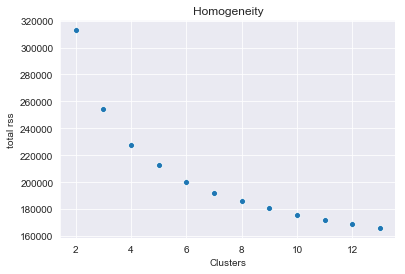

In [39]:
cluster_file_dkd,scores_dkd,centers_dkd=show_cluster_combined_model(shows.copy(),"sony-tv-show-dus-ka-dum-Mentions","combined",clstr=13)

Total tweets for starplus-show-kasautii-zindagi-kay-Mentions 190294 and unique tweets w/o processing 19894
unique tweets with processing 18170
The shape of embeddings  (18170, 100)
Counter({11: 3697, 3: 2779, 0: 2308, 10: 1842, 2: 1580, 9: 1435, 6: 924, 4: 921, 7: 848, 12: 710, 5: 525, 8: 476, 1: 125})


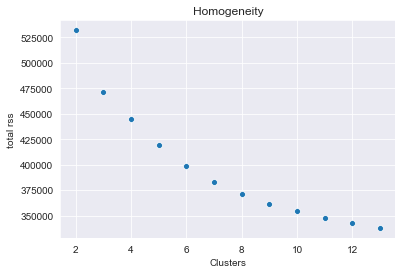

In [35]:
cluster_file,scores,centers=show_cluster_combined_model(shows.copy(),"starplus-show-kasautii-zindagi-kay-Mentions","combined",clstr=13)

Total tweets for zee-tv---show---ishq-subhan-allah-Mentions 12256 and unique tweets w/o processing 7470
unique tweets with processing 6451
The shape of embeddings  (6451, 100)
Counter({6: 1126, 1: 1005, 3: 913, 12: 738, 5: 554, 4: 435, 11: 370, 10: 267, 0: 264, 8: 243, 9: 230, 2: 165, 7: 141})


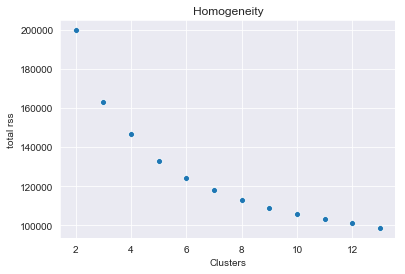

In [59]:
cluster_file_i,scores_i,centers_i=show_cluster_combined_model(shows.copy(),"zee-tv---show---ishq-subhan-allah-Mentions","combined",clstr=13)

In [60]:
distance=euclidean_distances(centers[11],centers_dkd[11])

print(distance)

distance.argmin(axis=1)

cd=cosine_distances(centers[11],centers_dkd[11])

cd.argmin(axis=1)

[[ 7.2732395   4.93515719 17.9859747  10.9248664   6.52224294 10.15261624
  10.47578726  6.16167221  9.49280014  6.89709684 12.8753988   9.48339863
   9.93147295]
 [15.59195675 16.71957452  0.94608599 16.15634464 14.38595339 12.50598383
  12.98520974 16.69392305 14.47990181 16.11059024 16.93440086 14.19306773
  15.02863879]
 [ 7.6225701   6.850019   16.11391355 10.66871453  6.03147996  8.01773413
   9.04945734  7.58067234  8.0962256   7.6959314  12.89647023  8.51125776
   8.85739385]
 [ 5.39068226  3.28213743 16.04195132  9.50316043  3.6147654   7.58158263
   8.25579419  5.25615898  6.96879969  5.28665966 11.96291404  7.55341728
   7.94175212]
 [ 8.98355568  8.28888316 17.26754478 11.5673411   8.0598561  10.00193008
  10.73642166  8.42645512  9.74629164  9.19842825 13.7502982   9.91002584
  10.21297685]
 [10.4949877  10.18124459 17.39003764 12.81836181  8.9674959   9.25509005
  11.42920837 10.67792382  9.86938078 10.86036813 15.33560248 10.61474876
  11.02748795]
 [10.51554973  9.79013

array([1, 2, 1, 1, 7, 1, 1, 4, 7, 8, 1, 1, 7], dtype=int64)

#### Trying EMmodelfor clustering

In [53]:
with open("starplus-show-kasautii-zindagi-kay-Mentions.embed",'rb') as rf:
    embeddings=pickle.load(rf)
em=mixture.GaussianMixture(n_components=13,covariance_type='full',random_state=101)
em.fit(embeddings)
labels=em.predict(embeddings)

In [57]:
cluster_file['em']=labels
cluster_file.to_csv("em_kas.csv")

In [58]:
Counter(labels)

Counter({0: 3939,
         1: 1300,
         2: 1225,
         3: 619,
         4: 2259,
         5: 1855,
         6: 513,
         7: 1057,
         8: 1600,
         9: 2220,
         10: 126,
         11: 727,
         12: 730})